This notebook pulls the data from the Features.parquet file and is used to validate that we preseve the data accross saves to parquet format. Data should compare with the develop_simple_features.ipynb

In [259]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import polars as pl

try:
    from sklearnex import patch_sklearn
except ImportError:
    %pip install scikit-learn-intelex
    from sklearnex import patch_sklearn
patch_sklearn()

from feature_utils import normalize_histogram
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import ListedColormap

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam, RMSprop

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# split the data into train, validation and test
from sklearn.model_selection import train_test_split

# pause warnings
import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [246]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path("data/train_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

meta_file = Path("data/meta_full.parquet")
if not meta_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, memory_map=True)
dfm = pl.read_parquet(meta_file, memory_map=True)
dft = dft.join(dfm, on="ClassId")
samples_per_class = 200
random_seed = 42
pl.set_random_seed(random_seed)
dft = pl.concat(
    [
        x.sample(samples_per_class, with_replacement=False, shuffle=False)
        for x in dft.partition_by("ClassId")
    ]
)
# del dfm

In [153]:
dft.head(1)

id,ClassId,Width,Height,Image,Resolution,Scaled_Meta_Image,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,LBP_Hist,HOG_Features,HOG_Image,Template_Pattern,RESNET101,VGG16,Path,ShapeId,ColorId,SignId,Description,Meta_Image,Meta_Width,Meta_Height,Meta_Resolution,Scaled_Meta_Width,Scaled_Meta_Height,Scaled_Meta_Image_right,Scaled_Meta_Resolution
i64,i64,i64,i64,binary,i64,binary,list[i64],list[i64],list[i64],binary,list[i64],list[f32],binary,list[f32],list[f64],list[f64],str,i64,i64,str,str,binary,i64,i64,i64,i64,i64,binary,i64
0,20,64,64,[binary data],4096,[binary data],"[544, 117, … 55]","[345, 185, … 0]","[0, 0, … 512]",[binary data],"[222, 165, … 0]","[0.09455, 0.0, … 0.0]",[binary data],"[0.166919, 0.152012, … 0.095363]","[0.77446, 0.0, … 0.0]","[0.0, 0.0, … 0.0]","""/work/06333/ed…",0,0,"""1.1""","""Right curve""",[binary data],88,100,8800,64,64,[binary data],4096


In [154]:
dft.shape

(8600, 30)

In [155]:
dft.columns

['id',
 'ClassId',
 'Width',
 'Height',
 'Image',
 'Resolution',
 'Scaled_Meta_Image',
 'Hue_Hist',
 'Saturation_Hist',
 'Value_Hist',
 'LBP_Image',
 'LBP_Hist',
 'HOG_Features',
 'HOG_Image',
 'Template_Pattern',
 'RESNET101',
 'VGG16',
 'Path',
 'ShapeId',
 'ColorId',
 'SignId',
 'Description',
 'Meta_Image',
 'Meta_Width',
 'Meta_Height',
 'Meta_Resolution',
 'Scaled_Meta_Width',
 'Scaled_Meta_Height',
 'Scaled_Meta_Image_right',
 'Scaled_Meta_Resolution']

In [156]:
columns = ['ClassId', 'Hue_Hist', 'Saturation_Hist', 'Value_Hist', 'LBP_Image', 'HOG_Features']
features = dft[columns]
features.head(1)

ClassId,Hue_Hist,Saturation_Hist,Value_Hist,LBP_Image,HOG_Features
i64,list[i64],list[i64],list[i64],binary,list[f32]
20,"[544, 117, … 55]","[345, 185, … 0]","[0, 0, … 512]",[binary data],"[0.09455, 0.0, … 0.0]"


In [157]:
# get features from each column in the dataframe

def get_lbp_features(df, columns):
    features = []
    numpy_stage1_train = df.with_columns(
        pl.col(columns[0]).map_elements(lambda x: np.load(BytesIO(x))).alias("NumPy")
    )
    X_train_LBP = np.asarray(numpy_stage1_train["NumPy"].to_list())
    del numpy_stage1_train
    X_train_LBP = np.reshape(
        X_train_LBP, (X_train_LBP.shape[0], X_train_LBP.shape[1] * X_train_LBP.shape[2])
    )
    return X_train_LBP


def get_features(df, columns):
    features = []
    for column in columns:
        # if column has more than one value, then vstack the values
        if len(df[column][0]) > 1:
            features.append(np.vstack(df[column]))
        else:
            features.append(df[column])
    # convert features to numpy array
    features = np.hstack(features)
    return features

In [228]:
hue = get_features(dft, ["Hue_Hist"])
saturation = get_features(dft, ["Saturation_Hist"])
lbp = get_lbp_features(dft, ["LBP_Image"])
hog = get_features(dft, ["HOG_Features"])
template = get_features(dft, ["Template_Pattern"])

# hog and template features only
features_hog_temp = np.hstack([hog, template])

# hue, hog and template features
features_hue_hog_temp = np.hstack([hue, hog, template])

# total features
ttl_features = np.hstack([hue, saturation, lbp, hog, template])

# print the shape of each feature
print("Hue shape: ", hue.shape)
print("Saturation shape: ", saturation.shape)
print("LBP shape: ", lbp.shape)
print("HOG shape: ", hog.shape)
print("Template shape: ", template.shape)
print("HOG + Template shape: ", features_hog_temp.shape)
print("Hue + HOG + Template shape: ", features_hue_hog_temp.shape)
print("Total features: ", ttl_features.shape)


Hue shape:  (8600, 180)
Saturation shape:  (8600, 256)
LBP shape:  (8600, 4096)
HOG shape:  (8600, 2916)
Template shape:  (8600, 3483)
HOG + Template shape:  (8600, 6399)
Hue + HOG + Template shape:  (8600, 6579)
Total features:  (8600, 10931)


In [229]:
# load pca_reduced total features from csv
hog_temp_pca = np.loadtxt(Path("data/features_hog_template_pca.csv"), delimiter=",") 
hog_temp_pca.shape


(8600, 231)

In [230]:
# get class labels
labels = dft["ClassId"].to_numpy()
labels.shape

(8600,)

In [231]:
# define a function to split the data into train, validation and test

def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    #normalize the data
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    return X_train, X_test, y_train, y_test

# create train and test data
X_train_hue, X_test_hue, y_train_hue, y_test_hue = split_data(hue, labels)
X_train_sat, X_test_sat, y_train_sat, y_test_sat = split_data(saturation, labels)
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = split_data(lbp, labels)
X_train_hog, X_test_hog, y_train_hog, y_test_hog = split_data(hog, labels)
X_train_temp, X_test_temp, y_train_temp, y_test_temp = split_data(template, labels)
X_train_hog_temp, X_test_hog_temp, y_train_hog_temp, y_test_hog_temp = split_data(features_hog_temp, labels)
X_train_hue_hog_temp, X_test_hue_hog_temp, y_train_hue_hog_temp, y_test_hue_hog_temp = split_data(features_hue_hog_temp, labels)
X_train_ttl, X_test_ttl, y_train_ttl, y_test_ttl = split_data(ttl_features, labels)
X_train_hog_temp_pca, X_test_hog_temp_pca, y_train_hog_temp_pca, y_test_hog_temp_pca = split_data(hog_temp_pca, labels)


In [227]:
print(X_train_hog.shape)
print(y_train_hog.shape)
print(X_train_hog_temp_pca.shape)
print(y_train_hog_temp_pca.shape)

(6880, 2916)
(6880,)
(6880, 231)
(6880,)


In [232]:
# get the input shape
ms_input_shape_hue = (X_train_hue.shape[1], 1)
ms_input_shape_sat = (X_train_sat.shape[1], 1)
ms_input_shape_lbp = (X_train_lbp.shape[1], 1)
ms_input_shape_hog = (X_train_hog.shape[1], 1)
ms_input_shape_temp = (X_train_temp.shape[1], 1)
ms_input_shape_hog_temp = (X_train_hog_temp.shape[1], 1)
ms_input_shape_hue_hog_temp = (X_train_hue_hog_temp.shape[1], 1)
ms_input_shape_ttl = (X_train_ttl.shape[1], 1)
ms_input_shape_hog_temp_pca = (X_train_hog_temp_pca.shape[1], 1)


In [163]:
ms_input_shape_hog_temp

(6399, 1)

### 1D Convolution Model

In [164]:
# define 1D CONV model
def create_cnn_model(padding='same',               
                    input_shape= ms_input_shape_hog,
                    learn_rate=0.001):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = Sequential()
    model.add(Conv1D(filters=6, kernel_size=21, strides=1, padding=padding, activation='relu', 
                    input_shape= input_shape,kernel_initializer=keras.initializers.he_normal()))
    model.add(BatchNormalization()) 
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Conv1D(filters=16, kernel_size=5, strides=1, padding=padding,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Flatten())
    model.add(Dense(120, activation='relu'))
    model.add(Dense(84))
    model.add(Dropout(rate=0.5, name='Dropout'))
    model.add(Dense(43, activation='softmax', name='Output'))
    model.compile(optimizer=Adam(learning_rate=learn_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

###########################################################################################################
# create model using the hog features and print the summary

###########################################################################################################
model_hog = create_cnn_model(input_shape=ms_input_shape_hog)
model_hog.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2916, 6)           132       
                                                                 
 batch_normalization (Batch  (None, 2916, 6)           24        
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 1458, 6)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 1458, 16)          496       
                                                                 
 batch_normalization_1 (Bat  (None, 1458, 16)          64        
 chNormalization)                                                
                                                        

In [233]:
# create model using the other individual features and total features
model_hue = create_cnn_model(input_shape=ms_input_shape_hue)
model_sat = create_cnn_model(input_shape=ms_input_shape_sat)
model_lbp = create_cnn_model(input_shape=ms_input_shape_lbp)
model_temp = create_cnn_model(input_shape=ms_input_shape_temp)
model_hog_temp = create_cnn_model(input_shape=ms_input_shape_hog_temp)
model_hog_temp_pca = create_cnn_model(input_shape=ms_input_shape_hog_temp_pca)
model_hue_hog_temp = create_cnn_model(input_shape=ms_input_shape_hue_hog_temp)
model_ttl = create_cnn_model(input_shape=ms_input_shape_ttl)


In [166]:
# create a callback list including early stopping and model checkpoint

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
    ]

# clear the session to reset tensorflow
tf.keras.backend.clear_session()



##### Train a model using the hog features

In [167]:
BATCH_SIZE = 32 
EPOCHS = 10

history_hog = model_hog.fit(X_train_hog,
                    y_train_hog,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/10
172/172 [==============================] - 12s 59ms/step - loss: 1.1937 - accuracy: 0.6690 - val_loss: 4.5267 - val_accuracy: 0.0189
Epoch 2/10
172/172 [==============================] - 11s 62ms/step - loss: 0.2260 - accuracy: 0.9313 - val_loss: 5.2777 - val_accuracy: 0.0189
Epoch 3/10
172/172 [==============================] - 11s 63ms/step - loss: 0.0901 - accuracy: 0.9709 - val_loss: 3.5035 - val_accuracy: 0.1759
Epoch 4/10
172/172 [==============================] - 11s 64ms/step - loss: 0.0541 - accuracy: 0.9829 - val_loss: 0.5374 - val_accuracy: 0.8547
Epoch 5/10
172/172 [==============================] - 11s 63ms/step - loss: 0.0461 - accuracy: 0.9840 - val_loss: 0.2673 - val_accuracy: 0.9339
Epoch 6/10
172/172 [==============================] - 11s 64ms/step - loss: 0.0348 - accuracy: 0.9887 - val_loss: 0.2305 - val_accuracy: 0.9440
Epoch 7/10
172/172 [==============================] - 12s 68ms/step - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.2705 - val_accuracy:

In [171]:
# The laste training and validation accuracy
print("The last training accuracy: ", history_hog.history['accuracy'][-1])
print("The last validation accuracy: ", history_hog.history['val_accuracy'][-1])

The last training accuracy:  0.9901889562606812
The last validation accuracy:  0.930232584476471


In [172]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_hog = model_hog.evaluate(X_test_hog, y_test_hog, batch_size=32)
# display the results in percentage and 2 decimal points
results_hog = [round(x,4) for x in results_hog]
print("test loss, test acc:", results_hog)


Evaluate on test data
54/54 [==============================] - 1s 15ms/step - loss: 0.2967 - accuracy: 0.9360
test loss, test acc: [0.2967, 0.936]


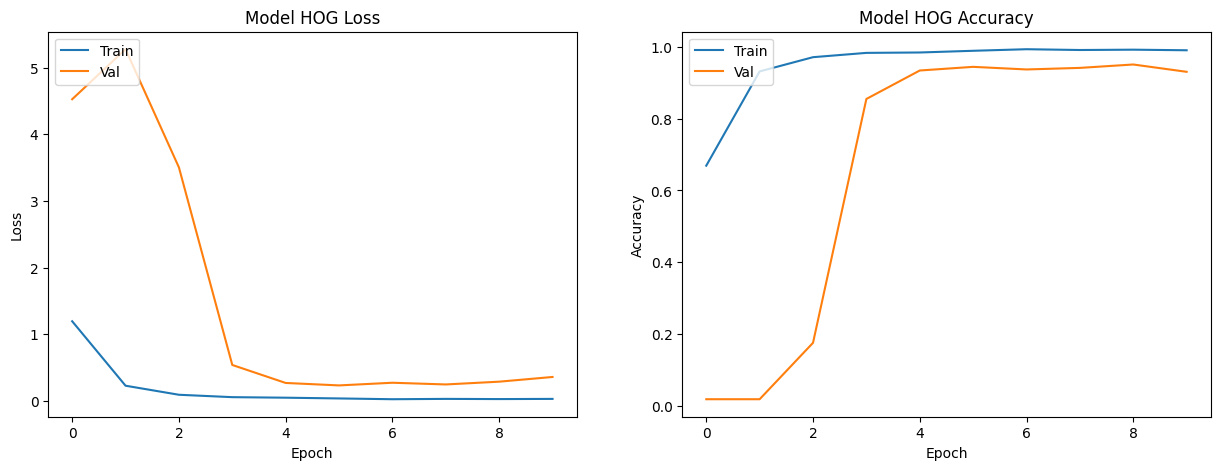

In [173]:
# define a function to plot the accuracy and loss for the model

def plot_accuracy_loss(history, name= "Model HOG"):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(name + ' Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')

    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(name + ' Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')

    plt.show()

plot_accuracy_loss(history_hog)


In [252]:
# Create a confusion matrix as a 2D array.
def plot_confusion_matrix(title, y_test, y_prediction):
    label_names = [f"Class {i}" for i in range(43)]

    confusion_matrix = tf.math.confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(12, 10))

    color_map1 = ['lightgrey', '#ffff99', 'orange', '#7fc97f']
    color_map = ListedColormap(color_map1)

    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap=color_map,
        linewidths=0.5,
        square=True,
        cbar_kws={"label": "Count"},
        xticklabels=label_names,
        yticklabels=label_names,
        annot_kws={"size": 10},
    )
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title(title + " Confusion Matrix", fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=80, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # Adjust layout to prevent cutoff of labels
    plt.tight_layout()

    # Add axis labels.
    # ax.set(xlabel="Predicted Label", ylabel="True Label")
    plt.show()
    return

Predicting ...
 1/54 [..............................] - ETA: 1s

54/54 [==============================] - 1s 12ms/step

Accuracy on Test Set: 93.6046511627907


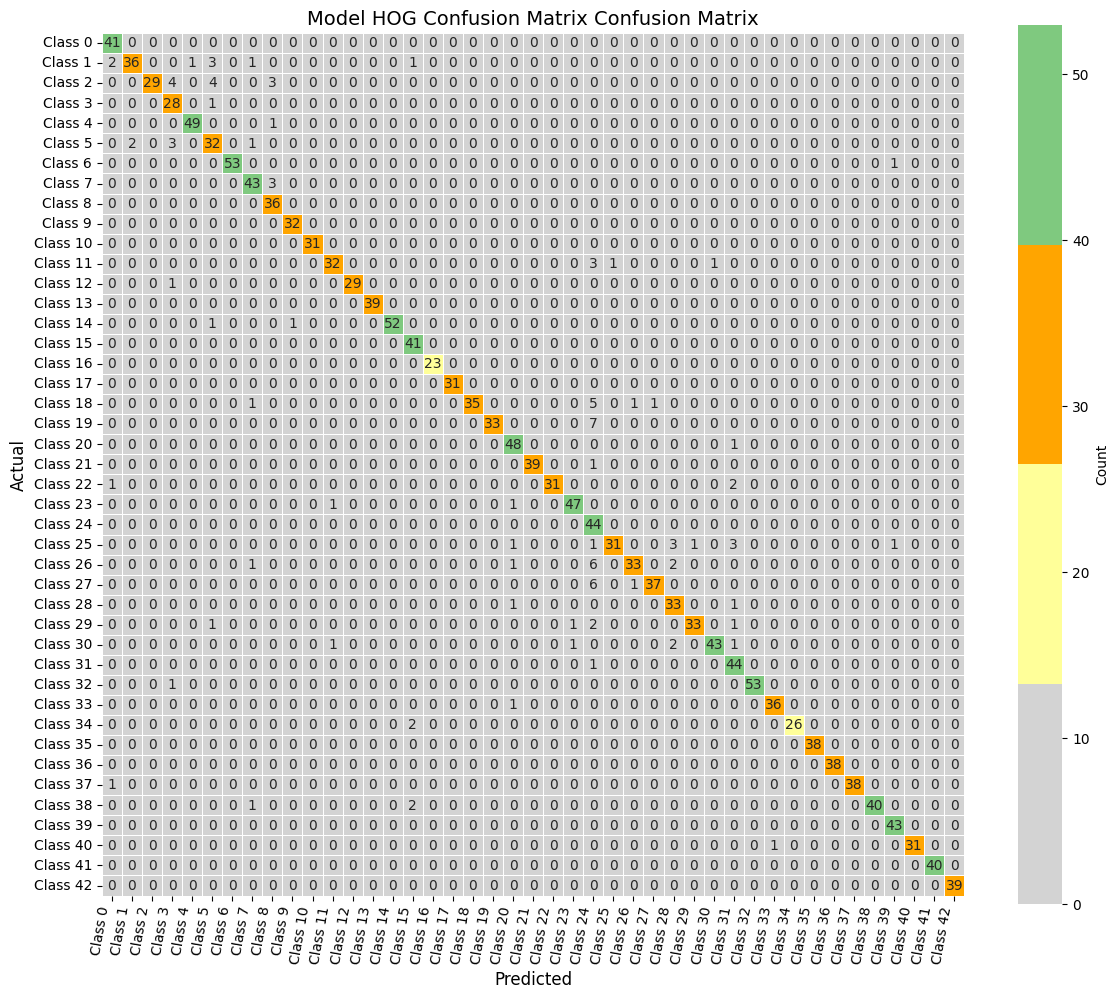

In [260]:
# comfusion matrix

# Predict
print('Predicting ...')
y_pred = model_hog.predict(X_test_hog)

y_prediction = np.full(shape=(y_pred.shape[0]), fill_value=-1)
row = 0
for p in y_pred:
    clase = np.argmax(p)
    y_prediction[row] = clase
    row+=1

accuracy = accuracy_score(y_test_hog, y_prediction)
print("\nAccuracy on Test Set:", accuracy*100)

plot_confusion_matrix('Model HOG Confusion Matrix', y_test_hog, y_prediction)


In [280]:
# get class 18 and 19 images that were misclassified as class 24
misclassified_images = []
for i in range(len(y_prediction)):
    if y_prediction[i] == 24 and y_test_hog[i] == 18:
        misclassified_images.append(X_test_hog[i])
    if y_prediction[i] == 24 and y_test_hog[i] == 19:
        misclassified_images.append(X_test_hog[i])

misclassified_images = np.asarray(misclassified_images)
misclassified_images.shape



(12, 2916)

##### Train a model using the Template features

Epoch 1/10


172/172 [==============================] - 12s 69ms/step - loss: 0.2527 - accuracy: 0.9215 - val_loss: 0.5031 - val_accuracy: 0.8808
Epoch 2/10
172/172 [==============================] - 12s 71ms/step - loss: 0.2437 - accuracy: 0.9233 - val_loss: 0.5678 - val_accuracy: 0.8517
Epoch 3/10
172/172 [==============================] - 12s 70ms/step - loss: 0.1999 - accuracy: 0.9317 - val_loss: 0.4934 - val_accuracy: 0.8888
Epoch 4/10
172/172 [==============================] - 11s 65ms/step - loss: 0.1814 - accuracy: 0.9449 - val_loss: 0.5157 - val_accuracy: 0.8859
Epoch 5/10
172/172 [==============================] - 11s 64ms/step - loss: 0.1784 - accuracy: 0.9442 - val_loss: 0.7581 - val_accuracy: 0.8256
Epoch 6/10
172/172 [==============================] - 11s 65ms/step - loss: 0.1662 - accuracy: 0.9479 - val_loss: 4.0273 - val_accuracy: 0.3619
Epoch 7/10
172/172 [==============================] - 11s 66ms/step - loss: 0.1363 - accuracy: 0.9564 - val_loss: 0.8607 - val_accuracy: 0.8249
Epo

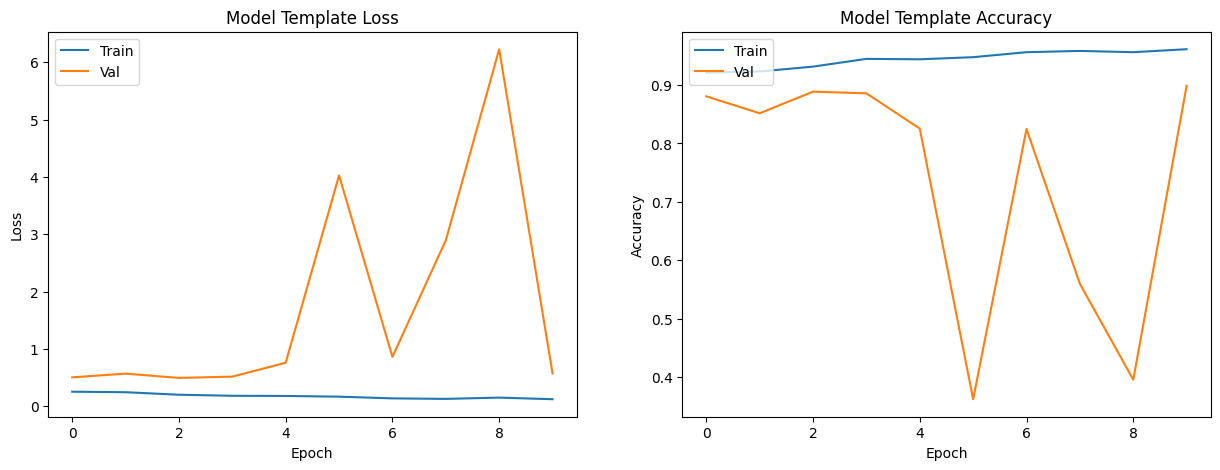

In [175]:
# train model to use the template features
history_temp = model_temp.fit(X_train_temp,
                    y_train_temp,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

plot_accuracy_loss(history_temp, "Model Template")

In [176]:
# The laste training and validation accuracy
print("The last training accuracy: ", history_temp.history['accuracy'][-1])
print("The last validation accuracy: ", history_temp.history['val_accuracy'][-1])

The last training accuracy:  0.961482584476471
The last validation accuracy:  0.898982584476471


In [177]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_temp = model_temp.evaluate(X_test_temp, y_test_temp, batch_size=32)
# display the results in percentage and 2 decimal points
results_temp = [round(x,4) for x in results_temp]
print("test loss, test acc:", results_temp)


Evaluate on test data
54/54 [==============================] - 1s 13ms/step - loss: 0.4162 - accuracy: 0.9093
test loss, test acc: [0.4162, 0.9093]


##### Train a model using the hog + template features reduced by PCA


##### Train a model with all Features

Epoch 1/10
172/172 [==============================] - 33s 181ms/step - loss: 4.4706 - accuracy: 0.0231 - val_loss: 3.7621 - val_accuracy: 0.0145
Epoch 2/10
172/172 [==============================] - 30s 176ms/step - loss: 3.7729 - accuracy: 0.0223 - val_loss: 3.7630 - val_accuracy: 0.0189
Epoch 3/10
172/172 [==============================] - 30s 173ms/step - loss: 3.7611 - accuracy: 0.0240 - val_loss: 3.7633 - val_accuracy: 0.0189
Epoch 4/10
172/172 [==============================] - 30s 175ms/step - loss: 3.7715 - accuracy: 0.0242 - val_loss: 3.7643 - val_accuracy: 0.0189
Epoch 5/10
172/172 [==============================] - 30s 174ms/step - loss: 3.7611 - accuracy: 0.0253 - val_loss: 3.7655 - val_accuracy: 0.0196
Epoch 6/10
172/172 [==============================] - 30s 175ms/step - loss: 3.7610 - accuracy: 0.0234 - val_loss: 3.7659 - val_accuracy: 0.0145
Epoch 7/10
172/172 [==============================] - 30s 175ms/step - loss: 3.7617 - accuracy: 0.0247 - val_loss: 3.7654 - val_ac

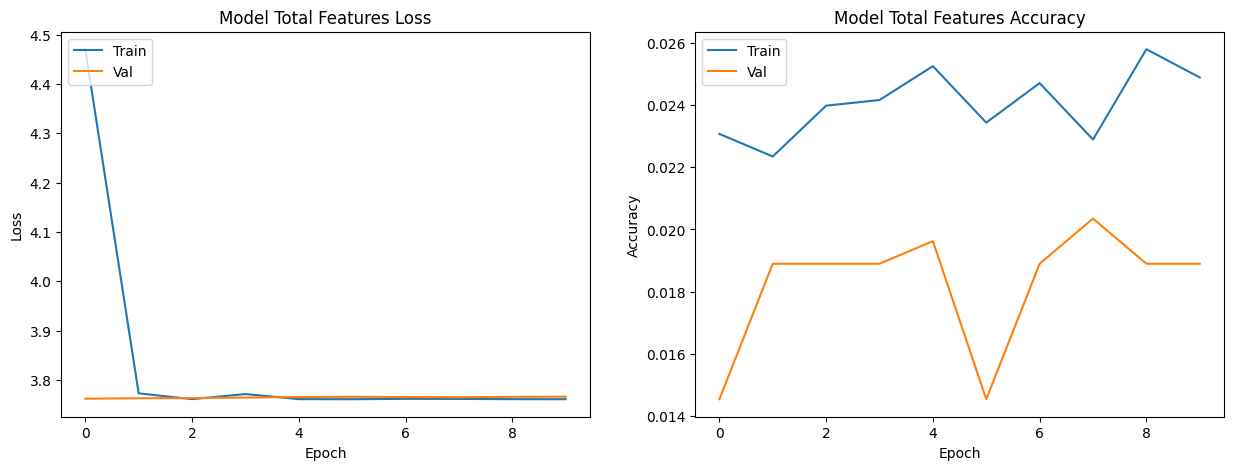

In [178]:
# train model to use the total features
history_ttl = model_ttl.fit(X_train_ttl,
                    y_train_ttl,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

plot_accuracy_loss(history_ttl, "Model Total Features")

In [179]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_ttl = model_ttl.evaluate(X_test_ttl, y_test_ttl, batch_size=32)
# display the results in percentage and 2 decimal points
results_ttl = [round(x,4) for x in results_ttl]
print("test loss, test acc:", results_ttl)

Evaluate on test data
54/54 [==============================] - 2s 28ms/step - loss: 3.7678 - accuracy: 0.0180
test loss, test acc: [3.7678, 0.018]


##### Train a model using the hog + template features

Epoch 1/10
172/172 [==============================] - 22s 119ms/step - loss: 1.8141 - accuracy: 0.5118 - val_loss: 3.8010 - val_accuracy: 0.0225
Epoch 2/10
172/172 [==============================] - 20s 114ms/step - loss: 0.3830 - accuracy: 0.8834 - val_loss: 3.7637 - val_accuracy: 0.0603
Epoch 3/10
172/172 [==============================] - 18s 106ms/step - loss: 0.1762 - accuracy: 0.9464 - val_loss: 2.6155 - val_accuracy: 0.4172
Epoch 4/10
172/172 [==============================] - 21s 120ms/step - loss: 0.0960 - accuracy: 0.9680 - val_loss: 0.3994 - val_accuracy: 0.9113
Epoch 5/10
172/172 [==============================] - 20s 115ms/step - loss: 0.0802 - accuracy: 0.9753 - val_loss: 0.2582 - val_accuracy: 0.9331
Epoch 6/10
172/172 [==============================] - 19s 109ms/step - loss: 0.0500 - accuracy: 0.9847 - val_loss: 0.2142 - val_accuracy: 0.9462
Epoch 7/10
172/172 [==============================] - 18s 106ms/step - loss: 0.0467 - accuracy: 0.9849 - val_loss: 0.1716 - val_ac

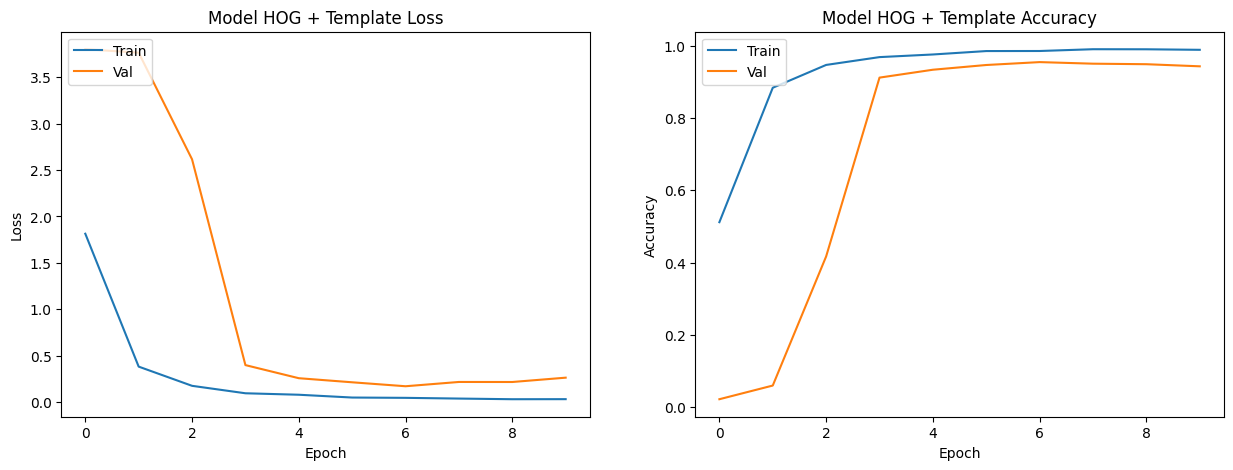

In [180]:
# train a model for hog and template features
EPOCHS = 10

history_hog_temp = model_hog_temp.fit(X_train_hog_temp,
                    y_train_hog_temp,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

plot_accuracy_loss(history_hog_temp, "Model HOG + Template")

In [181]:
# evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results_hog_temp = model_hog_temp.evaluate(X_test_hog_temp, y_test_hog_temp, batch_size=32)
# display the results in percentage and 2 decimal points
results_hog_temp = [round(x,4) for x in results_hog_temp]
print("test loss, test acc:", results_hog_temp)


Evaluate on test data
54/54 [==============================] - 1s 21ms/step - loss: 0.1542 - accuracy: 0.9634
test loss, test acc: [0.1542, 0.9634]


###  Efficiency vs Accuracy Analysis

In [199]:
# define a model to iterate over the different parameters

def create_cnn_model_2(filters=[6,16], kernel_size=[21,5], strides=1, padding='same',               
                    input_shape= ms_input_shape_hog,
                    learn_rate=0.001,
                    dense_layer=[120, 84],
                    dropout=0.5,                    
                    ):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)  
    print("Creating model with parameters: ")
    print("filters: ", filters, "kernel_size: ", kernel_size, "strides: ", strides, "padding: ", padding, "input_shape: ", input_shape, "learn_rate: ", learn_rate, "dense_layer: ", dense_layer, "dropout: ", dropout) 
        
    model = Sequential()
    model.add(Conv1D(filters=filters[0], kernel_size=kernel_size[0], strides=strides, padding=padding, activation='relu', 
                    input_shape= input_shape,kernel_initializer=keras.initializers.he_normal()))
    model.add(BatchNormalization()) 
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Conv1D(filters=filters[1], kernel_size=kernel_size[1], strides=1, padding=padding,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding=padding))
    model.add(Flatten())   
    model.add(Dense(dense_layer[0], activation='relu'))
    model.add(Dense(dense_layer[1]))
    model.add(Dropout(rate=dropout, name='Dropout'))

    model.add(Dense(43, activation='softmax', name='Output'))
    model.compile(optimizer=Adam(learning_rate=learn_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# define a function to train the model and return the accuracy and loss

In [201]:
# train the model using different parameters and time the training

import time

def train_model(X_train, y_train, X_test, y_test, model_name, epochs=10, batch_size=32, callbacks_list=callbacks_list):
    start_time = time.time()
    history = model_name.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=0)
    end_time = time.time()
    train_time = end_time - start_time
    print("Time taken to train the model: ", train_time)
    # get the best result of the model
    best_train_acc = np.max(history.history['accuracy'])
    print("Best train accuracy of model: %.2f%%" % (best_train_acc*100))
    best_val_acc = np.max(history.history['val_accuracy'])
    last_train_acc = history.history['accuracy'][-1]
    last_val_acc = history.history['val_accuracy'][-1]
    print("Best validation accuracy of model: %.2f%%" % (best_val_acc*100))
    print("The last training accuracy: ", last_train_acc)
    print("The last validation accuracy: ", last_val_acc)

    # Evaluate the model on the test data using `evaluate`
    print("Evaluate on test data")
    results = model_name.evaluate(X_test, y_test, batch_size=32)
    # display the results in percentage and 2 decimal points
    results = [round(x,4) for x in results]
    test_acc = results[1]
    print("test loss, test acc:", results)
    return history, last_train_acc, last_val_acc, test_acc, train_time, epochs

In [202]:
dropout = 0.5
dense = [84, 64]
filters = [6,16]
kernel_size = [15, 5]
EPOCHS = 1
model_test = create_cnn_model_2(filters=filters, kernel_size=kernel_size, dense_layer=dense, dropout=dropout, input_shape=ms_input_shape_hog_temp)
history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog_temp, y_train_hog_temp, X_test_hog_temp, y_test_hog_temp, model_name=model_test, epochs=EPOCHS)

Creating model with parameters: 
filters:  [6, 16] kernel_size:  [15, 5] strides:  1 padding:  same input_shape:  (6399, 1) learn_rate:  0.001 dense_layer:  [84, 64] dropout:  0.5
Time taken to train the model:  19.677568197250366
Best train accuracy of model: 2.14%
Best validation accuracy of model: 2.54%
The last training accuracy:  0.021438954398036003
The last validation accuracy:  0.025436045601963997
Evaluate on test data
54/54 [==============================] - 1s 19ms/step - loss: 3.7633 - accuracy: 0.0233
test loss, test acc: [3.7633, 0.0233]


In [285]:
# create a dataframe to store the results of the different models
columns = ['Model', 'Epochs', 'Filter_Size', 'Kernel_Size', 'Dense_Layer', 'Dropout', 'Train_Accuracy', 'Val_Accuracy', 'Test_Accuracy', 'Train_Time' ]
results_df = pd.DataFrame(columns=columns)


In [215]:


# ITERATE OVER THE PARAMETERS AND TRAIN THE MODEL
EPOCHS = [5, 10]
filters = [[6,16], [12, 16]]
kernel_size = [21,5]
dense = [[120, 84], [84, 64]]
dropout = [0.5, 0.3]

count = 0
for epoch in EPOCHS:
    for filter in filters:
        for dense_layer in dense:
            for drop in dropout:
                print("#############################################################################################################")
                print("Epochs: ", epoch, "filters: ", filter, "dense_layer: ", dense_layer, "dropout: ", drop)
                model = create_cnn_model_2(filters=filter, kernel_size=kernel_size, dense_layer=dense_layer, dropout=drop, input_shape=ms_input_shape_hog_temp)
                history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog_temp, y_train_hog_temp, X_test_hog_temp, y_test_hog_temp, model_name=model, epochs=epoch)
                results_df.loc[count] = ['Model HOG + Template', epochs, filter, kernel_size, dense_layer, drop, last_train_acc, last_val_acc, test_acc, train_time]
                count += 1
                print("#############################################################################################################")

#############################################################################################################
Epochs:  5 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.5
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (6399, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.5
Time taken to train the model:  118.02409601211548
Best train accuracy of model: 96.33%
Best validation accuracy of model: 93.24%
The last training accuracy:  0.9632993936538696
The last validation accuracy:  0.9324128031730652
Evaluate on test data
54/54 [==============================] - 1s 24ms/step - loss: 0.1459 - accuracy: 0.9581
test loss, test acc: [0.1459, 0.9581]
#############################################################################################################
#############################################################################################################
Epochs:  5 filters:  [6, 16] dense_layer:  [12

In [216]:
results_df

,Model,Epochs,Filter_Size,Kernel_Size,Dense_Layer,Dropout,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Time
0,Model HOG + Template,5,"[6, 16]","[21, 5]","[120, 84]",0.5,0.963299,0.932413,0.9581,118.024096
1,Model HOG + Template,5,"[6, 16]","[21, 5]","[120, 84]",0.3,0.990371,0.919331,0.9314,100.407637
2,Model HOG + Template,5,"[6, 16]","[21, 5]","[84, 64]",0.5,0.969477,0.937500,0.9599,91.052601
3,Model HOG + Template,5,"[6, 16]","[21, 5]","[84, 64]",0.3,0.987100,0.864826,0.8895,101.727986
4,Model HOG + Template,5,"[12, 16]","[21, 5]","[120, 84]",0.5,0.980378,0.904797,0.8953,118.181296
5,Model HOG + Template,5,"[12, 16]","[21, 5]","[120, 84]",0.3,0.980015,0.938227,0.9488,132.842125
6,Model HOG + Template,5,"[12, 16]","[21, 5]","[84, 64]",0.5,0.972929,0.936773,0.9570,111.385841
7,Model HOG + Template,5,"[12, 16]","[21, 5]","[84, 64]",0.3,0.985102,0.928052,0.9483,126.542759
8,Model HOG + Template,10,"[6, 16]","[21, 5]","[120, 84]",0.5,0.980741,0.920785,0.9395,197.705155
9,Model HOG + Template,10,"[6, 16]","[21, 5]","[120, 84]",0.3,0.993278,0.940407,0.9622,195.818760


In [247]:
# save the results to csv
results_df.to_csv(Path("data/results_hog_temp.csv"), index=False)



In [286]:
#create another dataframe to store the results of the different models
results_hog_df = pd.DataFrame(columns=columns)


In [287]:

# ITERATE OVER THE PARAMETERS AND TRAIN THE MODEL
EPOCHS = [5]
filters = [[6,16], [12, 16]]
kernel_size = [21,5]
dense = [[120, 84], [84, 64]]
dropout = [0.5, 0.3]

count = 0
for epoch in EPOCHS:
    for filter in filters:
        for dense_layer in dense:
            for drop in dropout:
                print("#############################################################################################################")
                print("Epochs: ", epoch, "filters: ", filter, "dense_layer: ", dense_layer, "dropout: ", drop)
                model = create_cnn_model_2(filters=filter, kernel_size=kernel_size, dense_layer=dense_layer, dropout=drop, input_shape=ms_input_shape_hog)
                history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog, y_train_hog, X_test_hog, y_test_hog, model_name=model, epochs=epoch)
                results_hog_df.loc[count] = ['Model HOG', epochs, filter, kernel_size, dense_layer, drop, last_train_acc, last_val_acc, test_acc, train_time]
                count += 1
                print("#############################################################################################################")

#############################################################################################################
Epochs:  5 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.5
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (2916, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.5
Time taken to train the model:  54.720529317855835
Best train accuracy of model: 98.66%
Best validation accuracy of model: 93.24%
The last training accuracy:  0.9865552186965942
The last validation accuracy:  0.9324128031730652
Evaluate on test data
54/54 [==============================] - 1s 12ms/step - loss: 0.2165 - accuracy: 0.9477
test loss, test acc: [0.2165, 0.9477]
#############################################################################################################
#############################################################################################################
Epochs:  5 filters:  [6, 16] dense_layer:  [12

In [261]:
results_hog_df

,Model,Epochs,Filter_Size,Kernel_Size,Dense_Layer,Dropout,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Time
0,Model HOG,5,"[6, 16]","[21, 5]","[120, 84]",0.5,0.990371,0.943314,0.9488,53.875323
1,Model HOG,5,"[6, 16]","[21, 5]","[120, 84]",0.3,0.993096,0.941134,0.9512,50.260327
2,Model HOG,5,"[6, 16]","[21, 5]","[84, 64]",0.5,0.982013,0.936773,0.9517,45.614954
3,Model HOG,5,"[6, 16]","[21, 5]","[84, 64]",0.3,0.990007,0.930959,0.9512,55.696575
4,Model HOG,5,"[12, 16]","[21, 5]","[120, 84]",0.5,0.986192,0.936773,0.9535,61.926431
5,Model HOG,5,"[12, 16]","[21, 5]","[120, 84]",0.3,0.993459,0.944041,0.9535,63.708628
6,Model HOG,5,"[12, 16]","[21, 5]","[84, 64]",0.5,0.982558,0.946221,0.9517,56.886693
7,Model HOG,5,"[12, 16]","[21, 5]","[84, 64]",0.3,0.993823,0.704215,0.7227,57.471590
8,Model HOG,10,"[6, 16]","[21, 5]","[120, 84]",0.5,0.987464,0.925145,0.9372,98.646460
9,Model HOG,10,"[6, 16]","[21, 5]","[120, 84]",0.3,0.992733,0.927326,0.9430,111.197594


In [265]:
# use columns to rename the columns of the dataframe

results_hog_df2 = pd.DataFrame(columns=columns)


In [266]:
EPOCHS = [10]
filters = [[6,16], [12, 16]]
kernel_size = [21,5]
dense = [[120, 84], [84, 64]]
dropout = [0.5, 0.3]

count = 0
for epoch in EPOCHS:
    for filter in filters:
        for dense_layer in dense:
            for drop in dropout:
                print("#############################################################################################################")
                print("Epochs: ", epoch, "filters: ", filter, "dense_layer: ", dense_layer, "dropout: ", drop)
                model = create_cnn_model_2(filters=filter, kernel_size=kernel_size, dense_layer=dense_layer, dropout=drop, input_shape=ms_input_shape_hog)
                history, last_train_acc, last_val_acc, test_acc, train_time, epochs = train_model(X_train_hog, y_train_hog, X_test_hog, y_test_hog, model_name=model, epochs=epoch)
                results_hog_df2.loc[count] = ['Model HOG', epochs, filter, kernel_size, dense_layer, drop, last_train_acc, last_val_acc, test_acc, train_time]
                count += 1
                print("#############################################################################################################")

#############################################################################################################
Epochs:  10 filters:  [6, 16] dense_layer:  [120, 84] dropout:  0.5
Creating model with parameters: 
filters:  [6, 16] kernel_size:  [21, 5] strides:  1 padding:  same input_shape:  (2916, 1) learn_rate:  0.001 dense_layer:  [120, 84] dropout:  0.5
Time taken to train the model:  94.14262771606445
Best train accuracy of model: 99.45%
Best validation accuracy of model: 94.77%
The last training accuracy:  0.9938226938247681
The last validation accuracy:  0.9476743936538696
Evaluate on test data
54/54 [==============================] - 1s 13ms/step - loss: 0.1797 - accuracy: 0.9628
test loss, test acc: [0.1797, 0.9628]
#############################################################################################################
#############################################################################################################
Epochs:  10 filters:  [6, 16] dense_layer:  [1

In [267]:
# combine results_hog_df and results_hog_df2
results_hog_df = pd.concat([results_hog_df, results_hog_df2])
results_hog_df

,Model,Epochs,Filter_Size,Kernel_Size,Dense_Layer,Dropout,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Time
0,Model HOG,5,"[6, 16]","[21, 5]","[120, 84]",0.5,0.990371,0.943314,0.9488,53.875323
1,Model HOG,5,"[6, 16]","[21, 5]","[120, 84]",0.3,0.993096,0.941134,0.9512,50.260327
2,Model HOG,5,"[6, 16]","[21, 5]","[84, 64]",0.5,0.982013,0.936773,0.9517,45.614954
3,Model HOG,5,"[6, 16]","[21, 5]","[84, 64]",0.3,0.990007,0.930959,0.9512,55.696575
4,Model HOG,5,"[12, 16]","[21, 5]","[120, 84]",0.5,0.986192,0.936773,0.9535,61.926431
5,Model HOG,5,"[12, 16]","[21, 5]","[120, 84]",0.3,0.993459,0.944041,0.9535,63.708628
6,Model HOG,5,"[12, 16]","[21, 5]","[84, 64]",0.5,0.982558,0.946221,0.9517,56.886693
7,Model HOG,5,"[12, 16]","[21, 5]","[84, 64]",0.3,0.993823,0.704215,0.7227,57.471590
8,Model HOG,10,"[6, 16]","[21, 5]","[120, 84]",0.5,0.987464,0.925145,0.9372,98.646460
9,Model HOG,10,"[6, 16]","[21, 5]","[120, 84]",0.3,0.992733,0.927326,0.9430,111.197594


In [268]:
# save the results to csv
results_hog_df.to_csv(Path("data/results_hog.csv"), index=False)
